# Trackbar Data Visualization

## Libraries

In [2]:
import os
import pandas as pd
import numpy as np
import SimpleITK as sitk
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

## Functions

In [ ]:
# Load images CT 3D
def load_image(file_path):
    mhd_file = [file for file in os.listdir(file_path) if file.endswith('.mhd')][0]
    mhd_path = os.path.join(file_path, mhd_file)
    image = sitk.ReadImage(mhd_path)
    image_array = sitk.GetArrayFromImage(image)
    return image_array

def plot_axial_slice_with_slider(image):
    def update_slice(slice_index):
        plt.figure(figsize=(16,10))
        plt.imshow(image[slice_index, :, :], cmap='gray')
        plt.show()

    slice_slider = widgets.IntSlider(min=0, max=image.shape[0] - 1, description='Slice Index')
    slice_slider.layout.width = '80%'  # Adjust width
    slice_slider.layout.margin = '30px 0 0 100px'  # Adjust margin
    widgets.interact(update_slice, slice_index=slice_slider)

def plot_sagittal_slice_with_slider(image):
    def update_slice(slice_index):
        sagittal_slice = image[:, :, slice_index]
        mirrored_slice = np.flipud(sagittal_slice)  # Flip the slice vertically
        plt.figure(figsize=(12,8))
        plt.imshow(mirrored_slice, cmap='gray')
        plt.show()

    slice_slider = widgets.IntSlider(min=0, max=image.shape[1] - 1, description='Slice Index')
    slice_slider.layout.width = '80%'  # Adjust width
    slice_slider.layout.margin = '30px 0 0 100px'  # Adjust margin
    widgets.interact(update_slice, slice_index=slice_slider)

def plot_coronal_slice_with_slider(image):
    def update_slice(slice_index):
        plt.figure(figsize=(12,8))
        plt.imshow(np.rot90(image[:, slice_index, :], k=2), cmap='gray')
        plt.show()

    slice_slider = widgets.IntSlider(min=0, max=image.shape[2] - 1, description='Slice Index')
    slice_slider.layout.width = '80%'  # Adjust width
    slice_slider.layout.margin = '30px 0 0 100px'  # Adjust margin
    widgets.interact(update_slice, slice_index=slice_slider)





## Get annotations coordinates

In [ ]:
file_path = "E:/6th year/maia work/2. Italy - Cassino/Project-Multi-Disciplinary/Data/Test_file"
annotations_path = "E:/6th year/maia work/2. Italy - Cassino/Project-Multi-Disciplinary/Data/annotations.csv"

if not os.path.exists(file_path):
    print("File path does not exist.")

if not os.path.exists(annotations_path):
    print("Annotations CSV file does not exist.")

annotations_df = pd.read_csv(annotations_path)
print("Annotations DataFrame:")
print(annotations_df.head(3))

mhd_files = [file for file in os.listdir(file_path) if file.endswith('.mhd')]
if not mhd_files:
    print("No CT scan files found.")
else:
    series_uid = os.path.splitext(mhd_files[0])[0]
    print("Extracted series UID:", series_uid)
    
    df_filtered = annotations_df[annotations_df['seriesuid'] == series_uid]

    print(f"Annotations for series UID {series_uid}:")
    print(df_filtered)

Annotations DataFrame:
                                           seriesuid      coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -128.699421 -175.319272   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.783651 -211.925149   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...   69.639017 -140.944586   

       coordZ  diameter_mm  
0 -298.387506     5.651471  
1 -227.121250     4.224708  
2  876.374496     5.786348  
Extracted series UID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326
Annotations for series UID 1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326:
                                             seriesuid     coordX    coordY  \
367  1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986...  56.239802 -92.28983   

        coordZ  diameter_mm  
367 -277.09856     8.982987  


## Trackbar function for Axial Sagittal and Coronal Slices

In [ ]:
image_array = load_image(file_path)

# Plot axial slice with slider
plot_axial_slice_with_slider(image_array)

# Plot sagittal slice with slider
plot_sagittal_slice_with_slider(image_array)

# Plot coronal slice with slider
plot_coronal_slice_with_slider(image_array)

interactive(children=(IntSlider(value=0, description='Slice Index', layout=Layout(margin='30px 0 0 100px', wid…

interactive(children=(IntSlider(value=0, description='Slice Index', layout=Layout(margin='30px 0 0 100px', wid…

interactive(children=(IntSlider(value=0, description='Slice Index', layout=Layout(margin='30px 0 0 100px', wid…

## Annotation matching Axial

  0%|          | 0/1 [00:00<?, ?it/s]

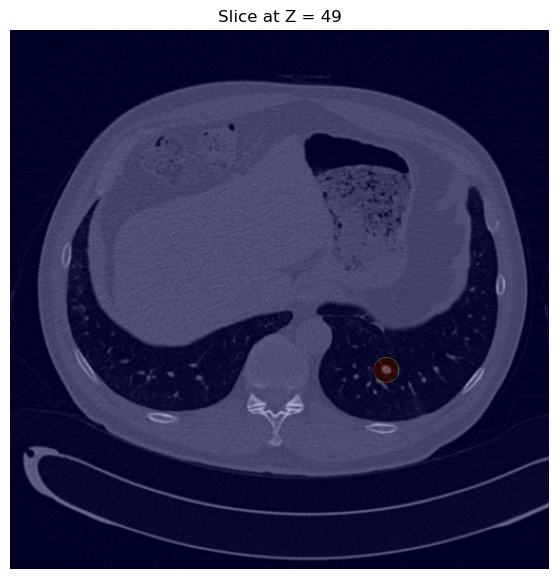

100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


In [6]:
from pathlib import Path
import os
import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
try:
    from tqdm import tqdm  # long waits are not fun
except:
    print('TQDM does make much nicer wait bars...')
    tqdm = lambda x: x

# Some helper functions


def make_mask(center, diam, z, width, height, spacing, origin):
    '''
Center: centers of circles px -- list of coordinates x,y,z
diam: diameters of circles px -- diameter
widthXheight: pixel dim of image
spacing = mm/px conversion rate np array x,y,z
origin = x,y,z mm np.array
z = z position of slice in world coordinates mm
    '''
    mask = np.zeros([height, width]) # 0's everywhere except nodule swapping x,y to match img
    # convert to nodule space from world coordinates

    # Defining the voxel range in which the nodule falls
    v_center = (center-origin)/spacing
    v_diam = int(diam/spacing[0]+5)
    v_xmin = np.max([0,int(v_center[0]-v_diam)-5])
    v_xmax = np.min([width-1,int(v_center[0]+v_diam)+5])
    v_ymin = np.max([0,int(v_center[1]-v_diam)-5]) 
    v_ymax = np.min([height-1,int(v_center[1]+v_diam)+5])

    v_xrange = range(v_xmin, v_xmax+1)
    v_yrange = range(v_ymin, v_ymax+1)

    # Convert back to world coordinates for distance calculation
    x_data = [x*spacing[0]+origin[0] for x in range(width)]
    y_data = [x*spacing[1]+origin[1] for x in range(height)]

    # Fill in 1 within sphere around nodule
    for v_x in v_xrange:
        for v_y in v_yrange:
            p_x = spacing[0]*v_x + origin[0]
            p_y = spacing[1]*v_y + origin[1]
            if np.linalg.norm(center-np.array([p_x, p_y, z])) <= diam:
                mask[int((p_y-origin[1])/spacing[1]), int((p_x-origin[0])/spacing[0])] = 1.0
    return mask


############

# Set your image path
file_path = "E:/6th year/maia work/2. Italy - Cassino/Project-Multi-Disciplinary/Data/Test_file"
annotations_path = "E:/6th year/maia work/2. Italy - Cassino/Project-Multi-Disciplinary/Data/annotations.csv"

# Getting list of image files
file_list = glob(file_path + "/*.mhd")


#####################
#
# Helper function to get rows in data frame associated 
# with each file
def get_filename(file_list, case):
    for f in file_list:
        if case in f:
            return f

# The locations of the nodes
df_node = pd.read_csv(annotations_path)
df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(file_list, file_name))
df_node = df_node.dropna()

#####
#
# Looping over the image files
#
for _, img_file in enumerate(tqdm(file_list)):
    mini_df = df_node[df_node["file"]==img_file]  #get all nodules associate with file
    if mini_df.shape[0] > 0:  # some files may not have a nodule--skipping those
        # load the data once
        itk_img = sitk.ReadImage(img_file) 
        img_array = sitk.GetArrayFromImage(itk_img)  # indexes are z,y,x (notice the ordering)
        num_z, height, width = img_array.shape        # heightXwidth constitute the transverse plane
        origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
        spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
        
        for node_idx, cur_row in mini_df.iterrows():       
            node_x = cur_row["coordX"]
            node_y = cur_row["coordY"]
            node_z = cur_row["coordZ"]
            diam = cur_row["diameter_mm"]
            # just keep 1 slice
            imgs = np.ndarray([1, height, width], dtype=np.float32)
            masks = np.ndarray([1, height, width], dtype=np.uint8)
            center = np.array([node_x, node_y, node_z])   # nodule center
            v_center = np.rint((center-origin)/spacing)  # nodule center in voxel space (still x,y,z ordering)
            i_z = int(v_center[2])
            mask = make_mask(center, diam, i_z*spacing[2]+origin[2],
                             width, height, spacing, origin)
            masks[0] = mask
            imgs[0] = img_array[i_z]
            
            # Plot the image with the nodule annotation
            fig, ax = plt.subplots(1, 1, figsize=(7, 7))
            ax.imshow(imgs[0], cmap='gray')
            ax.imshow(masks[0], cmap='jet', alpha=0.3)
            ax.set_title(f"Slice at Z = {i_z}")
            ax.axis('off')
            plt.show()


### Annotation function

In [ ]:
# Set your image path
file_path = "E:/6th year/maia work/2. Italy - Cassino/Project-Multi-Disciplinary/Data/Test_file"
annotations_path = "E:/6th year/maia work/2. Italy - Cassino/Project-Multi-Disciplinary/Data/annotations.csv"

# Getting list of image files
file_list = glob(file_path + "/*.mhd")


#####################
#
# Helper function to get rows in data frame associated 
# with each file
def get_filename(file_list, case):
    for f in file_list:
        if case in f:
            return f

# The locations of the nodes
df_node = pd.read_csv(annotations_path)
df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(file_list, file_name))
df_node = df_node.dropna()
print(df_node)
print("\n")
#####


def doAnnotation(df_node):

    def make_mask(center, diam, z, width, height, spacing, origin):

        mask = np.zeros([height, width]) # 0's everywhere except nodule swapping x,y to match img
        # convert to nodule space from world coordinates

        # Defining the voxel range in which the nodule falls
        v_center = (center-origin)/spacing
        v_diam = int(diam/spacing[0]+5)
        v_xmin = np.max([0,int(v_center[0]-v_diam)-5])
        v_xmax = np.min([width-1,int(v_center[0]+v_diam)+5])
        v_ymin = np.max([0,int(v_center[1]-v_diam)-5]) 
        v_ymax = np.min([height-1,int(v_center[1]+v_diam)+5])

        v_xrange = range(v_xmin, v_xmax+1)
        v_yrange = range(v_ymin, v_ymax+1)

        # Convert back to world coordinates for distance calculation
        x_data = [x*spacing[0]+origin[0] for x in range(width)]
        y_data = [x*spacing[1]+origin[1] for x in range(height)]

        # Fill in 1 within sphere around nodule
        for v_x in v_xrange:
            for v_y in v_yrange:
                p_x = spacing[0]*v_x + origin[0]
                p_y = spacing[1]*v_y + origin[1]
                if np.linalg.norm(center-np.array([p_x, p_y, z])) <= diam:
                    mask[int((p_y-origin[1])/spacing[1]), int((p_x-origin[0])/spacing[0])] = 1.0
        return mask


    ############

    #
    # Looping over the image files
    #
    for _, img_file in enumerate(tqdm(file_list)):
        mini_df = df_node[df_node["file"]==img_file]  #get all nodules associate with file
        if mini_df.shape[0] > 0:  # some files may not have a nodule--skipping those
            # load the data once
            itk_img = sitk.ReadImage(img_file) 
            img_array = sitk.GetArrayFromImage(itk_img)  # indexes are z,y,x (notice the ordering)
            num_z, height, width = img_array.shape        # heightXwidth constitute the transverse plane
            origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
            spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
            
            for node_idx, cur_row in mini_df.iterrows():       
                node_x = cur_row["coordX"]
                node_y = cur_row["coordY"]
                node_z = cur_row["coordZ"]
                diam = cur_row["diameter_mm"]
                # just keep 1 slice
                imgs = np.ndarray([1, height, width], dtype=np.float32)
                masks = np.ndarray([1, height, width], dtype=np.uint8)
                center = np.array([node_x, node_y, node_z])   # nodule center
                v_center = np.rint((center-origin)/spacing)  # nodule center in voxel space (still x,y,z ordering)
                i_z = int(v_center[2])
                mask = make_mask(center, diam, i_z*spacing[2]+origin[2],
                                width, height, spacing, origin)
                masks[0] = mask
                imgs[0] = img_array[i_z]
                
                # Plot the image with the nodule annotation
                # fig, ax = plt.subplots(1, 1, figsize=(7, 7))
                # ax.imshow(imgs[0], cmap='gray')
                # ax.imshow(masks[0], cmap='jet', alpha=0.3)
                # ax.set_title(f"Slice at Z = {i_z}")
                # ax.axis('off')
                # plt.show()

    
    
    df_f = df_filtered
    # change the list
def doAnnotationTotal(df_node):

    if df_node.empty:
        print("No more annotations")
        return
    
    doAnnotation(df_node)

    df_node.drop(index=df_node.index[0], axis=0, inplace=True)

    print("\n")

    print(df_node)

doAnnotationTotal(df_node)


                                             seriesuid     coordX    coordY  \
367  1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986...  56.239802 -92.28983   

        coordZ  diameter_mm                                               file  
367 -277.09856     8.982987  E:/6th year/maia work/2. Italy - Cassino/Proje...  




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.45it/s]




Empty DataFrame
Columns: [seriesuid, coordX, coordY, coordZ, diameter_mm, file]
Index: []


In [8]:
import os
import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display

try:
    from tqdm import tqdm  # long waits are not fun
except:
    print('TQDM does make much nicer wait bars...')
    tqdm = lambda x: x


df_node = pd.read_csv(annotations_path)
df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(file_list, file_name))
df_node = df_node.dropna()
print(df_node)
print("\n")
#####

# Plot axial slice with slider
def plot_axial_slice_with_slider(image):
    origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
    spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
    
    def update_slice(slice_index):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

        ax1.imshow(image[slice_index, :, :], cmap='gray')
        ax1.set_title("CT Image")
        ax1.axis('off')

        if slice_index == i_z:  # Display annotations only if the slice_index matches i_z
            ax2.imshow(imgs[0], cmap='gray')
            ax2.imshow(masks[0], alpha=0.4)
            ax2.set_title("Annotations")
        else:
            ax2.imshow(np.zeros_like(image[slice_index, :, :]), cmap='gray')  # Display black image
            ax2.set_title("No Annotations")

        ax2.axis('off')

        plt.show()


    slice_slider = widgets.IntSlider(min=0, max=image.shape[0] - 1, description='Slice Index')
    slice_slider.layout.width = '80%'  # Adjust width
    slice_slider.layout.margin = '30px 0 0 100px'  # Adjust margin
    widgets.interact(update_slice, slice_index=slice_slider)
    display(slice_slider)

# Load image
image_array = load_image(file_path)

# Plot axial slice with slider
# plot_axial_slice_with_slider(image_array)

                                             seriesuid     coordX    coordY  \
367  1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986...  56.239802 -92.28983   

        coordZ  diameter_mm                                               file  
367 -277.09856     8.982987  E:/6th year/maia work/2. Italy - Cassino/Proje...  




In [9]:
while not df_node.empty:
    doAnnotationTotal(df_node)
    plot_axial_slice_with_slider(image_array)

100%|██████████| 1/1 [00:00<00:00,  8.70it/s]



Empty DataFrame
Columns: [seriesuid, coordX, coordY, coordZ, diameter_mm, file]
Index: []


interactive(children=(IntSlider(value=0, description='Slice Index', layout=Layout(margin='30px 0 0 100px', wid…

IntSlider(value=0, description='Slice Index', layout=Layout(margin='30px 0 0 100px', width='80%'), max=194)

## Same for Sagittal:

In [ ]:
from pathlib import Path
import os
import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
try:
    from tqdm import tqdm  # long waits are not fun
except:
    print('TQDM does make much nicer wait bars...')
    tqdm = lambda x: x

# Some helper functions


def make_mask(center, diam, z, width, height, spacing, origin):
    '''
Center: centers of circles px -- list of coordinates x,y,z
diam: diameters of circles px -- diameter
widthXheight: pixel dim of image
spacing = mm/px conversion rate np array x,y,z
origin = x,y,z mm np.array
z = z position of slice in world coordinates mm
    '''
    mask = np.zeros([height, width]) # 0's everywhere except nodule swapping x,y to match img
    # convert to nodule space from world coordinates

    # Defining the voxel range in which the nodule falls
    v_center = (center-origin)/spacing
    v_diam = int(diam/spacing[0]+5)
    v_xmin = np.max([0,int(v_center[0]-v_diam)-5])
    v_xmax = np.min([width-1,int(v_center[0]+v_diam)+5])
    v_ymin = np.max([0,int(v_center[1]-v_diam)-5]) 
    v_ymax = np.min([height-1,int(v_center[1]+v_diam)+5])

    v_xrange = range(v_xmin, v_xmax+1)
    v_yrange = range(v_ymin, v_ymax+1)

    # Convert back to world coordinates for distance calculation
    x_data = [x*spacing[0]+origin[0] for x in range(width)]
    y_data = [x*spacing[1]+origin[1] for x in range(height)]

    # Fill in 1 within sphere around nodule
    for v_x in v_xrange:
        for v_y in v_yrange:
            p_x = spacing[0]*v_x + origin[0]
            p_y = spacing[1]*v_y + origin[1]
            if np.linalg.norm(center-np.array([p_x, p_y, z])) <= diam:
                mask[int((p_y-origin[1])/spacing[1]), int((p_x-origin[0])/spacing[0])] = 1.0
    return mask


############

# Set your image path
file_path = "E:/6th year/maia work/2. Italy - Cassino/Project-Multi-Disciplinary/Data/Test_file"
annotations_path = "E:/6th year/maia work/2. Italy - Cassino/Project-Multi-Disciplinary/Data/annotations.csv"

# Getting list of image files
file_list = glob(file_path + "/*.mhd")


#####################
#
# Helper function to get rows in data frame associated 
# with each file
def get_filename(file_list, case):
    for f in file_list:
        if case in f:
            return f

# The locations of the nodes
df_node = pd.read_csv(annotations_path)
df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(file_list, file_name))
df_node = df_node.dropna()

#####
#
# Looping over the image files
for _, img_file in enumerate(tqdm(file_list)):
    mini_df = df_node[df_node["file"]==img_file]  #get all nodules associate with file
    if mini_df.shape[0] > 0:  # some files may not have a nodule--skipping those
        # load the data once
        itk_img = sitk.ReadImage(img_file) 
        img_array = sitk.GetArrayFromImage(itk_img)  # indexes are z,y,x (notice the ordering)
        num_z, height, width = img_array.shape        # heightXwidth constitute the transverse plane
        origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
        spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
        
        for node_idx, cur_row in mini_df.iterrows():       
            node_x = cur_row["coordX"]
            node_y = cur_row["coordY"]
            node_z = cur_row["coordZ"]
            diam = cur_row["diameter_mm"]
            # just keep 1 slice
            imgs = np.ndarray([1, height, num_z], dtype=np.float32)  # Adjusted dimensions for sagittal slice
            masks = np.ndarray([1, height, num_z], dtype=np.uint8)   # Adjusted dimensions for sagittal slice
            center = np.array([node_x, node_y, node_z])   # nodule center
            v_center = np.rint((center-origin)/spacing)  # nodule center in voxel space (still x,y,z ordering)
            i_x = int(v_center[0])  # Index for sagittal slice
            
            # Check if the index is within bounds
            if i_x >= 0 and i_x < width:
                # Select sagittal slice
                sagittal_slice = img_array[:, :, i_x]
                
                
                # Generate mask for sagittal slice
                mask = make_mask(center, diam, i_x*spacing[0]+origin[0],
                                 num_z, height, spacing, origin)
                print("Shape of sagittal_slice_mirrored:", sagittal_slice.shape)
                print("Shape of imgs[0]:", imgs[0].shape)
                # Store sagittal slice and mask
                imgs[0] = sagittal_slice.T
                masks[0] = mask
                
                # Plot the image with the nodule annotation
                fig, ax = plt.subplots(1, 1, figsize=(7, 7))

                # Print mask values
                print("Mask values:", masks[0])

                # Flip the mask vertically
                masks_flipped = np.flipud(masks[0])

                ax.imshow(np.rot90(imgs[0]), cmap='gray', origin='upper')
                ax.imshow(np.rot90(masks_flipped), cmap='jet', alpha=0.5, origin='upper')
                ax.set_title(f"Sagittal Slice at X = {i_x}")
                ax.axis('off')
                plt.show()
# Plot the mask array directly
plt.imshow(masks[0], cmap='gray')
plt.title("Mask Array")
plt.colorbar()
plt.show()
